In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils import get_image_paths, word_from_image_path, preprocess_image, print_im, TextTransform, N_CHARS, SEQUENCE_LENGTH, IMAGE_DIMENSIONS
from utils import NgramTransform, load_trained_CNN_weights, base_cnn_in_keras, plot_batch_images, raw2gray
from multi_gpu import make_parallel
import time 
import datetime
from scipy.misc import imresize


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# good article : 
# https://github.com/da03/Attention-OCR 

# data set from 
# http://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html

In [15]:
test_paths = '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/'

In [16]:
files_paths = get_image_paths(test_paths)
files_paths_test_only = get_image_paths(os.path.join(test_paths,"test"))

In [17]:
len(files_paths)

3005

In [18]:
pic_list =['jpg', 'png']

In [19]:
images_paths = [s for s in files_paths_test_only if s[-3:] in pic_list]
other_files = [s for s in files_paths if s[-3:] not in pic_list]

In [20]:
print (len(images_paths), len(other_files))

3000 5


In [25]:
other_files

['/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/README',
 '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/testCharBound.mat',
 '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/testdata.mat',
 '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/trainCharBound.mat',
 '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/IIIT5K/traindata.mat']

In [22]:
from scipy.io import loadmat

In [26]:
testmat = loadmat(other_files[2])

In [27]:
labels = {}
for i in range(3000):
    labels[testmat['testdata'][0,i][0][0]] = testmat['testdata'][0,i][1][0]

In [33]:
# imgs
imgs = [load_img(im_path) for im_path in images_paths ]
img_array = np.array([imresize(img_to_array(img), (32,100)) for img in imgs])

In [34]:
# labels
imgs_labels = ["/".join(images_paths[i].split("/")[-2:]) for i in range(3000)]
imgs_labels = [labels[l] for l in imgs_labels]
imgs_labels = np.array(imgs_labels)

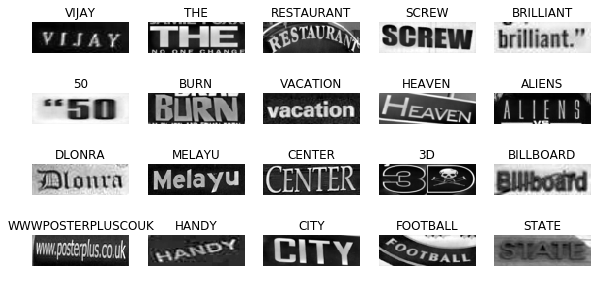

In [39]:
plot_batch_images(img_array, imgs_labels, name="benoit")

### Image pre-processing

In [38]:
## converting to gray 

img_array = np.array([raw2gray(img) for img in img_array])
img_array = np.array(img_array)

## scaling image
mean = img_array.mean(axis = (1,2))
std = img_array.std(axis = (1,2))
img_array = (img_array - mean.reshape(-1,1,1)) / std.reshape(-1,1,1)

##scaling columns
mean2 = img_array.mean(axis=0)
std2 = img_array.std(axis=0)
img_array = (img_array - mean2) / std2

### Opening Model

In [40]:
from keras.models import load_model

In [42]:
cnn_trained = load_model('cnn_trained.h5')

In [44]:
predictions = cnn_trained.predict(img_array.reshape(img_array.shape[0], 32, 100, 1))

In [45]:
predictions.shape

(3000, 23, 37)

In [47]:
import pickle
with open('tt_new.pickle', 'rb') as f:
    tt = pickle.load(f)

In [56]:
tt.word_from_matrix(predictions[0]) == imgs_labels[0].lower()

False

/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/utils.py:201: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if predictions == None:


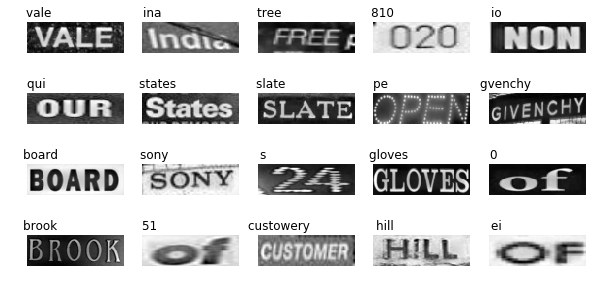

In [53]:
plot_batch_images(img_array, predictions, name="benoit", predictions = predictions)

In [72]:
### Accuracy measure
labels_predicted = np.array([tt.word_from_matrix(predictions[i]).replace(" ","") for i in range(3000)])
imgs_labels = np.array([imgs_labels[i].lower() for i in range(3000) ])

In [66]:
from sklearn.metrics import accuracy_score

In [71]:
import Levenshtein

In [86]:
lev_score = np.mean([Levenshtein.ratio(imgs_labels[i], labels_predicted[i]) for i in range(3000)])
print("Levenshtein average score : {:.2f}".format(lev_score))

Levenshtein average score : 0.62


In [89]:
acc_score = np.mean([imgs_labels[i]==labels_predicted[i] for i in range(3000)])
print("Average accuracy score : {:.2f}".format(acc_score))

Average accuracy score : 0.29
